<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>SSM: Path Enhancement</h1> 
</div>

<br/>

<p>
Following Section 4.2.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook a strategy for enhancing path structures in SSMs. This technique was originally introduced by Müller and Kurth. This functionality is also provided by the <a href="https://www.audiolabs-erlangen.de/resources/MIR/SMtoolbox"> SM Toolbox</a>.
    
Meinard Müller and Frank Kurth
Enhancing Similarity Matrices for Music Audio Analysis
In Proceedings of the 32th International Conference on Acoustics, Speech, and Signal Processing (ICASSP): 437–440,     
    
<ul>
<li><span style="color:black">
Meinard Müller and Frank Kurth: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2006_MuellerKurth_EnhancingSimilarityMatrices_ICASSP.pdf"><strong>Enhancing Similarity Matrices for Music Audio Analysis.</strong></a> Proceedings of the International Conference on Acoustics, Speech, and Signal Processing (ICASSP), Toulouse, France, 437–440, 2006.  
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerK06_EnhancingSimilarityMatrices_ICASSP.txt"> Bibtex </a>
</span></li>
<li><span style="color:black">
Meinard Müller, Nanzhu Jiang, and Harald Grohganz: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2014_MuellerJiangGrohganz_ToolboxSM_AES.pdf"><strong>SM Toolbox: MATLAB implementations for computing and enhancing similarity matrices.</strong></a> Proceedings of the 53rd AES Conference on Semantic Audio, London, UK, 2014.
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerJG14_SM-Toolbox_AES.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="https://www.audiolabs-erlangen.de/resources/MIR/SMtoolbox">MATLAB Toolbox</a>
</span></li>
</ul>    
</p> 

 

## Example: Brahms

As our running example in this notebook, we consider again the Ormandy recording of the [Hungarian Dance No. 5 by Johannes Brahms](../C4/C4S1_MusicStructureGeneral.html). As a feature representation, we use a [**chromagram**](../C3/C3S1_SpecLogFreq-Chromagram.html) with a feature resolution of $2~\mathrm{Hz}$

Orchestral version (Ormandy, $A_1A_2B_1B_2CA_3B_3B_4D$) <br clear="all" />
<audio style="width: 320px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.mp3" type="audio/mpeg" controls="controls"></audio>

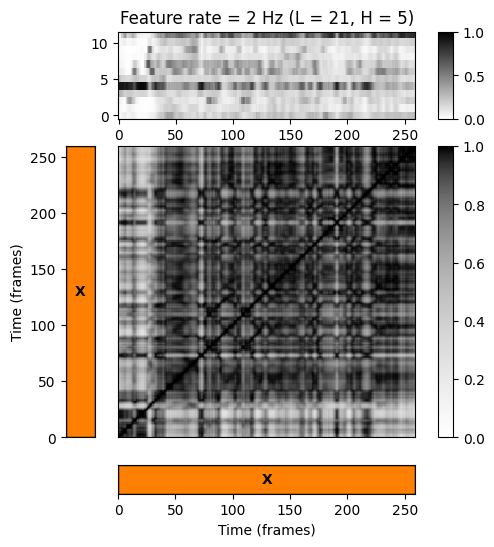

In [1]:
from CONST import get_wav, calculate_ann
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

%matplotlib inline

# Annotation
#filename = 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
#fn_ann = os.path.join('..', 'data', 'C4', filename)
#ann, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename)


# Waveform
# fn_wav = os.path.join('..', 'data', 'C4', 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav')
Fs = 22050
x, Fs = get_wav(Fs, '01 Main Theme (Aberration).wav')
ann, color_ann, x_duration = calculate_ann(x, Fs)

# Chroma Feature Sequence and SSM (10 Hz)
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=2205, n_fft=4410)
Fs_C = Fs/2205

# Chroma Feature Sequence and SSM (2 Hz)
L, H = 21, 5
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(C, Fs_C, 
                        filt_len=L, down_sampling=H)

X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = libfmp.c4.compute_sm_dot(X,X)
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim=[0,1], clim_X=[0,1],
            title='Feature rate = %0.0f Hz (L = %d, H = %d)'%(Fs_X,L,H))

## Diagonal Smoothing

One important property of similarity matrices is the appearance of paths of high similarity that are parallel to the main diagonal. Each such path encodes the similarity of two segments that are obtained by projecting the path onto the horizontal and vertical axes, respectively. The identification and extraction of such paths is the main step in many music analysis applications. However, due to musical and acoustic variations, the path structure is often very noisy and hard to extract. To some extent, such noise can be reduced simply by using longer analysis windows in the feature computation step and adjusting the feature rate. To further enhance the path structure, one general strategy is to apply some kind of smoothing filter along the direction of the main diagonal, resulting in an emphasis of diagonal information in $\mathbf{S}$ and a denoising of other structures. Such a filtering process, also referred to as **diagonal smoothing**, is closely related to the concept of **time-delay embedding**, which has been widely used for the analysis of dynamical systems. 

We now give a mathematical description of this procedure. Let $\mathbf{S}$ be an SSM of size $N\times N$ and let $L\in\mathbb{N}$ be a length of the smoothing filter. Then we define the smoothed self-similarity matrix $\mathbf{S}_L$ by setting

\begin{equation}
\mathbf{S}_L(n,m) := \frac{1}{L} \sum_{\ell=0}^{L-1} \mathbf{S}(n+\ell,m+\ell)
\end{equation}

for $n,m\in[1:N-L+1]$. By suitably extending $\mathbf{S}$ (e.g, by **zero-padding** where zero columns and rows are added), we may assume in the following that $\mathbf{S}_L(n,m)$ is defined for $n,m\in[1:N]$. 

In view of **efficiency issues**, we implement the smoothing procedure using matrix-based operations. The main idea of the implementation is as follows:

* We generate $\ell$-shifted versions of $\mathbf{S}$ for $\ell\in[0:L-1]$. To this end, we shift $\mathbf{S}$ by $\ell$ positions along the main diagonal. 
* Then, we sum up the $\ell$-shifted versions over $\ell\in[0:L-1]$. Dividing the resulting matrix by $L$ yields the matrix $\mathbf{S}_L$.
* To handle boundary effects, we use zero-padding starting with an $(N+L)$-square all-zero matrix.  

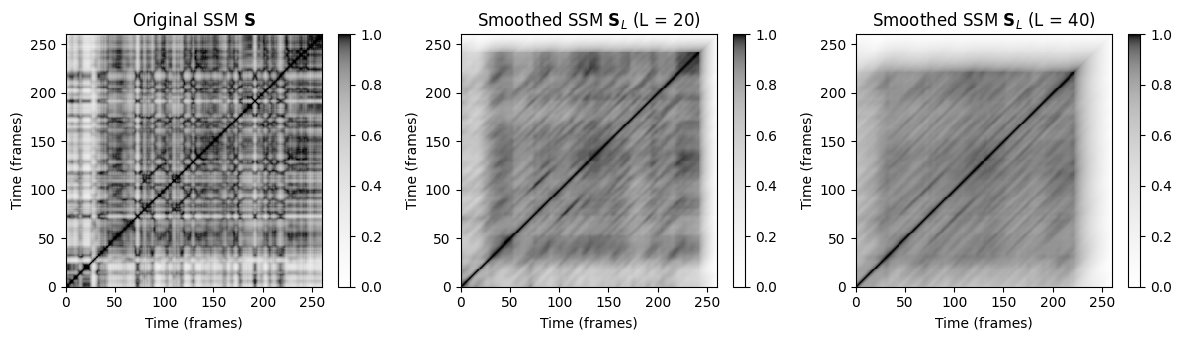

In [3]:
@jit(nopython=True)
def filter_diag_sm(S, L):
    """Path smoothing of similarity matrix by forward filtering along main diagonal

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S (np.ndarray): Similarity matrix (SM)
        L (int): Length of filter

    Returns:
        S_L (np.ndarray): Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    S_L = np.zeros((N, M))
    S_extend_L = np.zeros((N + L, M + L))
    S_extend_L[0:N, 0:M] = S
    for pos in range(0, L):
        S_L = S_L + S_extend_L[pos:(N + pos), pos:(M + pos)]
    S_L = S_L / L
    return S_L

def subplot_matrix_colorbar(S, fig, ax, title='', Fs=1,
                            xlabel='Time (seconds)', ylabel='Time (seconds)',
                            clim=None, xlim=None, ylim=None, cmap=None, interpolation='nearest'):
    """Visualization function for showing zoomed sections of matrices

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S: Similarity matrix (SM)
        fig: Figure handle
        ax: Axes handle
        title: Title for figure (Default value = '')
        Fs: Feature rate (Default value = 1)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Time (seconds)')
        clim: Color limits (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for x-axis (Default value = None)
        cmap: Colormap for imshow (Default value = None)
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        im: Imshow handle
    """
    if cmap is None:
        cmap = libfmp.b.compressed_gray_cmap(alpha=-100)
    len_sec = S.shape[0] / Fs
    extent = [0, len_sec, 0, len_sec]
    im = ax.imshow(S, aspect='auto', extent=extent, cmap=cmap,  origin='lower', interpolation=interpolation)
    fig.sca(ax)
    fig.colorbar(im)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)
    return im

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Original SSM $\mathbf{S}$')
L = 20
S_L = filter_diag_sm(S, L)
subplot_matrix_colorbar(S_L, fig, ax[1], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L)
L_long = 40
S_L_long = filter_diag_sm(S, L_long)
subplot_matrix_colorbar(S_L_long, fig, ax[2], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L_long)

plt.tight_layout()
plt.show()

A simple filtering along the main diagonal works well if there are no relative tempo differences between the segments to be compared. However, this assumption is violated when a part is repeated with a faster or slower tempo. In the Ormandy interpretation of our Brahms example this happens in the $B$-sections: the shorter $B_2$-section is played much faster than the $B_1$-section. It is only the beginning of the $B_2$-section that is played much faster than the beginning of the $B_1$-section, whereas the two sections have roughly the same tempo towards the end of the part. This results in a path that does not run exactly parallel to the main diagonal (in particular at the beginning), so that applying an averaging filter in the direction of the main diagonal destroys some of the path structure. This particularly happens if the filter length $L$ is large. 

Orchestral version (Ormandy, $B_1$) <br clear="all" />
<audio style="width: 320px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy_B1.mp3" type="audio/mpeg" controls="controls"></audio>

Orchestral version (Ormandy, $B_2$) <br clear="all" />
<audio style="width: 320px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy_B2.mp3" type="audio/mpeg" controls="controls"></audio>

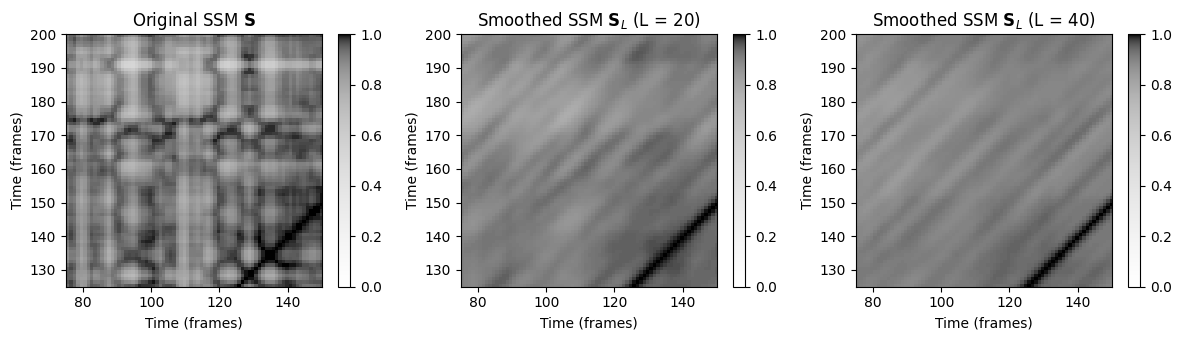

In [4]:
xlim = [75, 150]
ylim = [125, 200]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], xlim=xlim, ylim=ylim,
                        title=r'Original SSM $\mathbf{S}$', 
                        xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_L, fig, ax[1], clim=[0,1], xlim=xlim, ylim=ylim,
                        title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L, 
                        xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_L_long, fig, ax[2], clim=[0,1], xlim=xlim, ylim=ylim,
                        title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L_long, 
                        xlabel='Time (frames)', ylabel='Time (frames)')

plt.tight_layout()
plt.show()

## Multiple Filtering

To deal with non-diagonal path structures due relative tempo differences, we now introduce a **multiple filtering** approach that preserve such structures under certain assumptions. The main idea of this approach to filter a similarity matrix along various directions that lie in a neighborhood of the direction defined by the main diagonal. Each such direction corresponds to a tempo difference and results in a separate filtered similarity matrix. The final similarity matrix is obtained by taking the cell-wise maximum over all these matrices. In this way, the path structure is also enhanced in the presence of local tempo variations as illustrated in the following figure. 

A mathematical description of this procedure is as follows. First, let use assume the the tempo difference is given by a real number $\theta>0$. We define the self-similarity matrix smoothed in the direction of $(1,\theta)$ by

\begin{equation}
\mathbf{S}_{L,\theta}(n,m) := \frac{1}{L} \sum_{\ell=0}^{L-1} \mathbf{S}(n+\ell,m+[\ell\cdot\theta]),
\end{equation}

where $[\ell\cdot\theta]$ denotes the integer closest to the real number $\ell\cdot\theta$. Again, by suitably zero-padding the matrix $\mathbf{S}$, we may assume that $\mathbf{S}_{L,\theta}$ is defined for $n,m\in[1:N]$. Now, in practice, one does not know the local tempo difference that may occur in a given music recording. Also, the relative tempo difference between two repeating sections may change over time. Therefore, the idea is to consider a (finite) set $\Theta$ consisting of tempo parameters $\theta\in\Theta$ for different relative tempo differences. Then, we compute for each such $\theta$ a matrix $\mathbf{S}_{L,\theta}$ and obtain a final matrix $\mathbf{S}_{L,\Theta}$ by a cell-wise maximization over all $\theta\in\Theta$:

\begin{equation}
\mathbf{S}_{L,\Theta}(n,m) := \max_{\theta\in\Theta} \mathbf{S}_{L,\theta}(n,m).
\end{equation}

Note that choosing $\Theta=\{1\}$ reduces to the case $\mathbf{S}_{L,\Theta}=\mathbf{S}_{L}$. In practice, one can use prior information on the expected relative tempo differences to determine the set $\Theta$. For example, it rarely happens that the relative tempo difference between repeating segments is larger than $50$ percent, so that $\Theta$ can be chosen to cover tempo variations of roughly $-50$ to $+50$ percent. Furthermore, in practice, the tempo range can be covered well by considering only a relatively small number of tempo parameters. For example, the set 

$$
\Theta=\{0.66,0.81,1.00,1.22,1.50\}
$$ 

(with logarithmically spaced tempo parameters) covers tempo variations of roughly $-50$ to $+50$ percent. This set can be computed by the following function:

<!--$\Theta=\{ 0.50, 0.63, 0.79, 1.26, 1.59, 2.00 \}$ covering tempo variations of roughly $-100$ to $+100$ percent.-->

In [5]:
@jit(nopython=True)
def compute_tempo_rel_set(tempo_rel_min, tempo_rel_max, num):
    """Compute logarithmically spaced relative tempo values

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        tempo_rel_min (float): Minimum relative tempo
        tempo_rel_max (float): Maximum relative tempo
        num (int): Number of relative tempo values (inlcuding the min and max)

    Returns:
        tempo_rel_set (np.ndarray): Set of relative tempo values
    """
    tempo_rel_set = np.exp(np.linspace(np.log(tempo_rel_min), np.log(tempo_rel_max), num))
    return tempo_rel_set

tempo_rel_min = 0.66
tempo_rel_max = 1.5
num = 5
tempo_rel_set = compute_tempo_rel_set(tempo_rel_min=tempo_rel_min, tempo_rel_max=tempo_rel_max, num=num) 
print(tempo_rel_set)

[0.66       0.81036517 0.99498744 1.22167146 1.5       ]


The smoothing length parameter $L\in\mathbb{N}$ and discrete set $\Theta$ of relative tempo differences are the two main parameters for controlling the smoothing quality. Similar to the diagonal smoothing, our **implementation** of the multiple filtering approach is expressed in terms of full matrix operations, which can be efficiently computed. The main idea of the implementation is as follows:

* For each tempo parameter $\theta\in\Theta$, we resample the SSM along one axis by a factor determined by $\theta$. The resampling simulates the relative tempo difference specified by $\theta$.  
* We apply diagonal filtering of lenght $L$ for each resampled matrix.
* Each filtered matrix is converted back to the original format again by applying (reverse) resampling.
* Taking the cell-weise maximum of the resulting matrices for $\theta\in\Theta$, one obtains the matrix $\mathbf{S}_{L,\Theta}$.

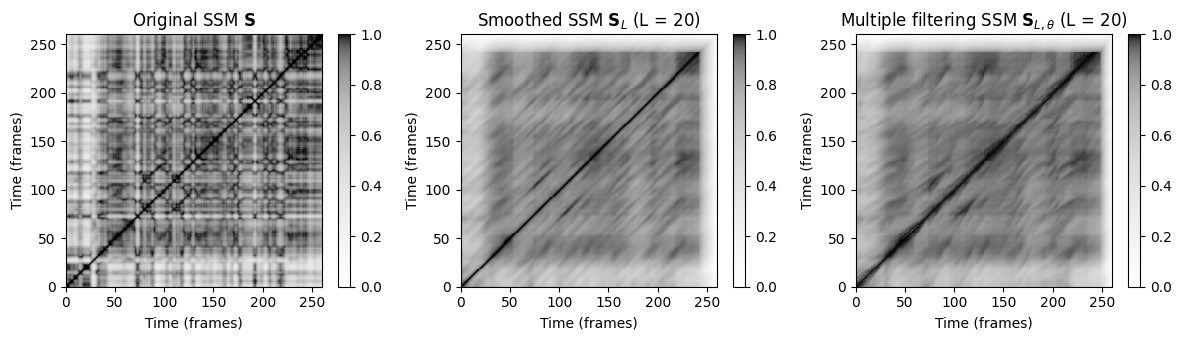

In [6]:
@jit(nopython=True)
def filter_diag_mult_sm(S, L=1, tempo_rel_set=np.asarray([1]), direction=0):
    """Path smoothing of similarity matrix by filtering in forward or backward direction
    along various directions around main diagonal.
    Note: Directions are simulated by resampling one axis using relative tempo values

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)
        L (int): Length of filter (Default value = 1)
        tempo_rel_set (np.ndarray): Set of relative tempo values (Default value = np.asarray([1]))
        direction (int): Direction of smoothing (0: forward; 1: backward) (Default value = 0)

    Returns:
        S_L_final (np.ndarray): Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    num = len(tempo_rel_set)
    S_L_final = np.zeros((N, M))

    for s in range(0, num):
        M_ceil = int(np.ceil(M / tempo_rel_set[s]))
        resample = np.multiply(np.divide(np.arange(1, M_ceil+1), M_ceil), M)
        np.around(resample, 0, resample)
        resample = resample - 1
        index_resample = np.maximum(resample, np.zeros(len(resample))).astype(np.int64)
        S_resample = S[:, index_resample]

        S_L = np.zeros((N, M_ceil))
        S_extend_L = np.zeros((N + L, M_ceil + L))

        # Forward direction
        if direction == 0:
            S_extend_L[0:N, 0:M_ceil] = S_resample
            for pos in range(0, L):
                S_L = S_L + S_extend_L[pos:(N + pos), pos:(M_ceil + pos)]

        # Backward direction
        if direction == 1:
            S_extend_L[L:(N+L), L:(M_ceil+L)] = S_resample
            for pos in range(0, L):
                S_L = S_L + S_extend_L[(L-pos):(N + L - pos), (L-pos):(M_ceil + L - pos)]

        S_L = S_L / L
        resample = np.multiply(np.divide(np.arange(1, M+1), M), M_ceil)
        np.around(resample, 0, resample)
        resample = resample - 1
        index_resample = np.maximum(resample, np.zeros(len(resample))).astype(np.int64)

        S_resample_inv = S_L[:, index_resample]
        S_L_final = np.maximum(S_L_final, S_resample_inv)

    return S_L_final

tempo_rel_min = 0.66
tempo_rel_max = 1.5
num = 5
tempo_rel_set = compute_tempo_rel_set(tempo_rel_min=tempo_rel_min, tempo_rel_max=tempo_rel_max, num=num) 
L = 20
S_L = filter_diag_sm(S, L)
S_L_mult = filter_diag_mult_sm(S, L, tempo_rel_set)

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Original SSM $\mathbf{S}$')
subplot_matrix_colorbar(S_L, fig, ax[1], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L)
subplot_matrix_colorbar(S_L_mult, fig, ax[2], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Multiple filtering SSM $\mathbf{S}_{L,\theta}$ (L = %d)'%L)

plt.tight_layout()
plt.show()

In the following figure, we again zoom into the SSMs comparing the $B_1$-section (horizontal axis) with the $B_2$-section (vertical axis).

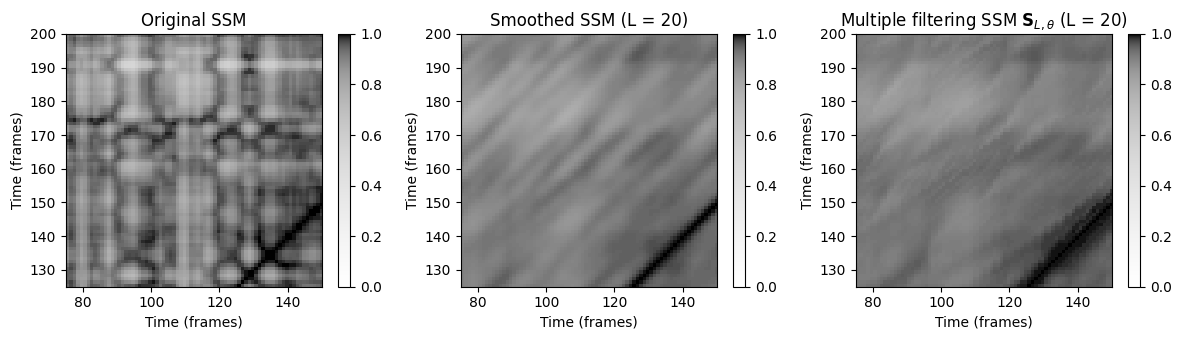

In [7]:
xlim = [75, 150]
ylim = [125, 200]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], xlim=xlim, ylim=ylim,
                        title='Original SSM', xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_L, fig, ax[1], clim=[0,1], xlim=xlim, ylim=ylim,
                        title='Smoothed SSM (L = %d)'%L, xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_L_mult, fig, ax[2], clim=[0,1], xlim=xlim, ylim=ylim,
                        title=r'Multiple filtering SSM $\mathbf{S}_{L,\theta}$ (L = %d)'%L, 
                        xlabel='Time (frames)', ylabel='Time (frames)')

plt.tight_layout()
plt.show()

## Forward&ndash;Backward Smoothing

This previous figure shows that there is a fading artifact in particular at the end of path structures. The reason for this artifact is that our smoothing procedure described so far works in the forward direction. To avoid fading artifacts, one idea is to additionally apply the averaging filter in a backward direction. The final self-similarity matrix is then obtained by taking the cell-wise maximum over the **forward-smoothed** and **backward-smoothed** matrices.

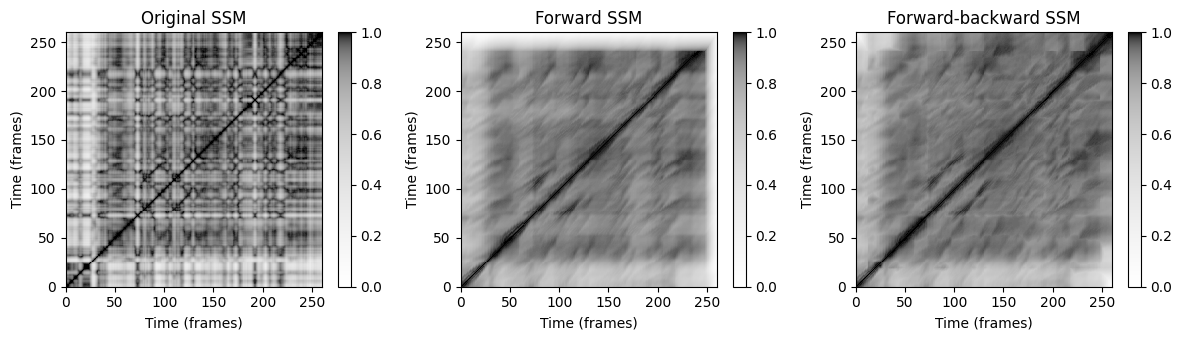

In [8]:
tempo_rel_min = 0.66
tempo_rel_max = 1.5
num = 5
tempo_rel_set = compute_tempo_rel_set(tempo_rel_min=tempo_rel_min, tempo_rel_max=tempo_rel_max, num=num) 
L = 20
S_forward = filter_diag_mult_sm(S, L, tempo_rel_set, direction=0)
S_backward = filter_diag_mult_sm(S, L, tempo_rel_set, direction=1)
S_final = np.maximum(S_forward, S_backward)

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], 
                        title=r'Original SSM', xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_forward, fig, ax[1], clim=[0,1],
                        title=r'Forward SSM', xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_final, fig, ax[2], clim=[0,1], 
                        title=r'Forward-backward SSM', xlabel='Time (frames)', ylabel='Time (frames)')

plt.tight_layout()
plt.show()

In the following figure, we again zoom into the SSMs comparing the $B_1$-section (horizontal axis) with the $B_2$-section (vertical axis).

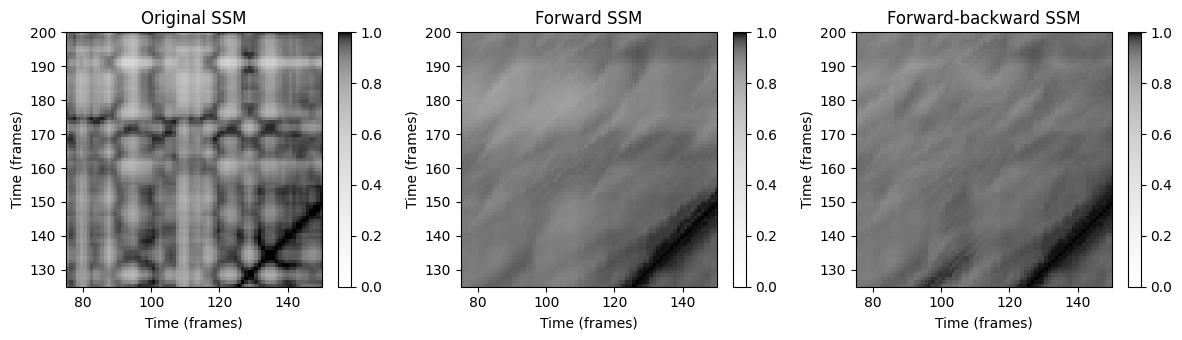

In [9]:
xlim = [75, 150]
ylim = [125, 200]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], xlim=xlim, ylim=ylim,
                        title='Original SSM', xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_forward, fig, ax[1], clim=[0,1], xlim=xlim, ylim=ylim,
                        title='Forward SSM', xlabel='Time (frames)', ylabel='Time (frames)')
subplot_matrix_colorbar(S_final, fig, ax[2], clim=[0,1], xlim=xlim, ylim=ylim,
                        title='Forward-backward SSM', xlabel='Time (frames)', ylabel='Time (frames)')

plt.tight_layout()
plt.show()

## Further Notes

In the research literature, one finds a large number of contributions that apply some sort of augmentation of path-like structures. Most enhancement procedures are based on smoothing the given matrix along the direction of the main diagonal. Such a filtering process is closely related to the concept of **time-delay embedding**, which has been previously used for the analysis of dynamical systems. Also **morphological operations** used in image processing to enhance contours and 
edges can be applied for augmenting path-like structures. For a links to the research literature, we refer to Section 4.6.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. The multiple filtering approach to deal with relative tempo differences between repeating parts was originally suggested in the article <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2006_MuellerKurth_EnhancingSimilarityMatrices_ICASSP.pdf"><strong>Enhancing Similarity Matrices for Music Audio Analysis.</strong></a> There are various ways to implement similar procedures. An alternative to our **resample-based approach** is to apply multiple **2D convolution kernels** (one kernel for each direction) as implemented in [LibROSA](https://librosa.org/doc). Another modification could be to use **median filtering** (instead of averaging filtering) to avoid fading artifacts.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and David Kopyto.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>